In [6]:
import json
import unicodedata
import re
import pandas as pd
pd.set_option('max_colwidth',1000)
from lxml import objectify
import numpy as np



from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer

from string import punctuation

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer      

from SVM import *
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#Required packages from nltk
#nltk.download('punkt')
#nltk.download('stopwords')

## Load CSV file or create from XML

In [2]:
try:
    general_tweets_corpus_train = pd.read_csv('datasets/csv/general-tweets-train-tagged.csv', encoding='utf-8')
except:
    xml = objectify.parse(open('datasets/xml/general-tweets-train-tagged.xml'))
    #sample tweet object
    root = xml.getroot()
    general_tweets_corpus_train = pd.DataFrame(columns=('content', 'polarity', 'agreement'))
    tweets = root.getchildren()
    for i in range(0,len(tweets)):
        tweet = tweets[i]
        row = dict(zip(['content', 'polarity', 'agreement'], 
                       [tweet.content.text, tweet.sentiments.polarity.value.text, 
                        tweet.sentiments.polarity.type.text]))
        row_s = pd.Series(row)
        row_s.name = i
        general_tweets_corpus_train = general_tweets_corpus_train.append(row_s)
    general_tweets_corpus_train.to_csv('datasets/csv/general-tweets-train-tagged.csv', index=False, encoding='utf-8')

In [3]:
tweets_corpus = pd.concat([general_tweets_corpus_train])
tweets_corpus = tweets_corpus.query('agreement != "DISAGREEMENT" and polarity != "NONE"')
tweets_corpus = tweets_corpus[-tweets_corpus.content.str.contains('^http.*$')]
tweets_corpus.sample(5)

,content,polarity,agreement
4091,No estoy a favor de primarias. La enmienda de Henríquez es a título personal. Ya lo dijo él y así lo he dicho hoy a preguntas de periodistas,NEU,AGREEMENT
2130,El Gobierno no ampliará el plazo para que sindicatos y empresarios lleguen a un acuerdo,N,AGREEMENT
4013,"Diego Torres se niega a declarar por el caso Noos.Puede decir: Señoría Vd no me ha protegido mi derecho al honor,no ha guardado el sumario!",N,AGREEMENT
7117,A los q nos han llevado a una situación en la q se hace insostenible el Estado de Bienestar solo se les ocurre criticar sin dar soluciones?,N,AGREEMENT
1162,Que grande.. Ahora me volvia 20 años atras.. :P http://t.co/Z5koQuSV,P,AGREEMENT


In [4]:
try:
    general_tweets_corpus_test = pd.read_csv('datasets/csv/general-tweets-test1k.csv')#, encoding='utf-8')
except:
    xml = objectify.parse(open('datasets/xml/general-tweets-test1k.xml'))
    #sample tweet object
    root = xml.getroot()
    general_tweets_corpus_test = pd.DataFrame(columns=('content', 'polarity'))
    tweets = root.getchildren()
    for i in range(0,len(tweets)):
        tweet = tweets[i]
        row = dict(zip(['content'], [tweet.content.text]))
        row_s = pd.Series(row)
        row_s.name = i
        general_tweets_corpus_test = general_tweets_corpus_test.append(row_s)
    general_tweets_corpus_test.to_csv('datasets/csv/general-tweets-test1k.csv', index=False)#, encoding='utf-8')


In [5]:
tweets_test = pd.concat([general_tweets_corpus_test])

tweets_test.sample(5)

,content,polarity
8,Por cierto muy recomendable en Madrid la exposición de Yves Saint Laurent http://t.co/j1PIiLis,NaN
400,"En 2012, habrá 200 millones d parados en el mundo, 27 millones se pueden achacar directamente a crisis, datos Org. Internacional del Trabajo",NaN
860,El Prado de #Málaga es «imparable». @eliasbendodo @javierarenas_pp @jiwert http://t.co/g0eJ5HQK,NaN
595,Voy a comer... Hasta luego!!!,NaN
548,El miedito se llama despido procedente x causas objetivas: 20 días si la empresa tiene pérdida d intresos o ventas 3 trim. consecutivos.,NaN


In [6]:
try:
    tagged_tweets_corpus_test = pd.read_csv('datasets/csv/general-tweets-test1k-tagged.csv', encoding='utf-8')
except:

    from lxml import objectify
    xml = objectify.parse(open('datasets/xml/general-tweets-test1k-tagged.xml'))
    #sample tweet object
    root = xml.getroot()
    tagged_tweets_corpus_test = pd.DataFrame(columns=('content', 'polarity'))
    tweets = root.getchildren()
    for i in range(0,len(tweets)):
        tweet = tweets[i]
        row = dict(zip(['content', 'polarity', 'agreement'], [tweet.content.text, tweet.sentiments.polarity.value.text]))
        row_s = pd.Series(row)
        row_s.name = i
        tagged_tweets_corpus_test = tagged_tweets_corpus_test.append(row_s)
    tagged_tweets_corpus_test.to_csv('datasets/csv/general-tweets-test1k-tagged.csv', index=False, encoding='utf-8')

In [7]:
tweets_tagged = pd.concat([tagged_tweets_corpus_test])
tweets_tagged = tweets_tagged.query('polarity != "NONE"')
diff = np.setdiff1d(tweets_test.index.values, tweets_tagged.index.values)

tweets_test = tweets_test.drop(diff)
tweets_tagged.sample(5)


,content,polarity
751,"El acuerdo de recorte de derechos laborales aprobada por PP, CIU, UPN y FAC, es un ataque brutal que debe tener justa respuesta global.",N
997,@carlos__alsina la oferta se mantiene para cualquier día y en 140 caracteres no es fácil pero intento en el siguiente.,N
985,@PabloAIglesias un abrazo fuerte. Te lo doy pronto en persona.,P+
32,#Rajoy recibe con rostro serio y circunspecto las palabras de saludo y deseos de éxito en su gestión de Jose Bono.,P+
594,"""Sólo avanzada ya mi vida me di cuenta de cuán fácil es decir: no lo sé"" William Somerset Maugham",P+


## Tokenize and Stems Sentences 

In [8]:
#Stem: Cut word in root (wait: wait, waited: wait, waiting: wait)
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#Each word is a token
def tokenize(text):
    text = ''.join([c for c in text if c not in non_words])
    tokens =  word_tokenize(text)

    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

In [9]:
#Stopwords: Empty word (i.e articles)

spanish_stopwords = stopwords.words('spanish')
stemmer = SnowballStemmer('spanish')


#Non Words: Symbols and Numbers
non_words = list(punctuation)
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))


## Creating Model (Linear SVM) and Training

In [10]:
#Binarizing

tweets_corpus['polarity_bin'] = 0
index = tweets_corpus.polarity.isin(['P', 'P+'])
tweets_corpus.polarity_bin.loc[index] = 1
print tweets_corpus.polarity_bin.value_counts(normalize=True)

tweets_test['polarity_bin'] = 0

tweets_tagged['polarity_bin'] = 0
index = tweets_tagged.polarity.isin(['P', 'P+'])
tweets_tagged.polarity_bin.loc[index] = 1
tweets_tagged.polarity_bin.value_counts(normalize=True)

y = tweets_tagged.polarity_bin.values

tweets_corpus.sample(3)

1    0.53994
0    0.46006
Name: polarity_bin, dtype: float64


/usr/lib/python2.7/dist-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,content,polarity,agreement,polarity_bin
5260,Estoy con un Citadelle Reserve (el Rolls Royce de los gin tonics) a la salud de los miles que habéis mandado hoy tuits de todo tipo. Gcs.,P,AGREEMENT,1
3204,Peque ya en el cole y a empezar ;-)) (@ Pinosol) http://t.co/N56vd1vp,P+,AGREEMENT,1
1049,"Alfonso Alonso reprocha a antigüedad que no haya condenado a ETA desde la tribuna del parlamento. ""Debemos ser especialmente exigentes"".",N,AGREEMENT,0


# Find Parameters

In [ ]:
vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LinearSVC()),
])



parameters = {
    'vect__max_df': (0.5, 1.9),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'cls__C': (0.2, 0.5, 0.7),
    'cls__loss': ('hinge', 'squared_hinge'),
    'cls__max_iter': (500, 1000)
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1 , scoring='roc_auc')
grid_search.fit(tweets_corpus.content, tweets_corpus.polarity_bin)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: 

In [11]:
best_params = {'vect__ngram_range': (1, 2), 'cls__loss': 'hinge', 'vect__max_df': 0.5
 , 'cls__max_iter': 1000, 'vect__min_df': 10, 'vect__max_features': 1000
 , 'cls__C': 0.2}

best_pipe = Pipeline([
    ('vect', CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,
            stop_words = spanish_stopwords,
            min_df = 10,
            max_df = 0.5,
            ngram_range=(1, 2),
            max_features=1000
            )),
    ('cls', LinearSVC(C=.2, loss='hinge',max_iter=1000,multi_class='ovr',
             random_state=None,
             penalty='l2',
             tol=0.0001
             )),
])

best_pipe.fit(tweets_corpus.content, tweets_corpus.polarity_bin)
best_test = tweets_test
best_test['polarity_bin'] = best_pipe.predict(best_test.content)



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [71]:
y_b = best_test.polarity_bin.values
best_result = np.abs(y_b - y)
np.bincount(best_result)[0]/float(best_result.shape[0])


0.80398162327718226

In [72]:
pipeline = Pipeline([
    ('vect', CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,
            stop_words = spanish_stopwords,
            min_df = 50,
            max_df = 1.9,
            ngram_range=(1, 1),
            max_features=1000
            )),
    ('cls', LinearSVC(C=.2, loss='squared_hinge',max_iter=1000,multi_class='ovr',
             random_state=None,
             penalty='l2',
             tol=0.0001
             )),
])

pipeline.fit(tweets_corpus.content, tweets_corpus.polarity_bin)
tweets_test['polarity_bin'] = pipeline.predict(tweets_test.content)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [73]:
y_t = tweets_test.polarity_bin.values
result = np.abs(y_t - y)
np.bincount(result)[0]/float(result.shape[0])


0.71975497702909652

In [74]:
p = pipeline.fit(tweets_corpus.content, tweets_corpus.polarity_bin)

scores = cross_val_score(p, tweets_corpus.content, tweets_corpus.polarity_bin, cv=5)

np.mean(scores)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


0.68227481108362864

In [38]:
best_scores = cross_val_score(best_pipe, tweets_corpus.content, tweets_corpus.polarity_bin, cv=5)

np.mean(best_scores)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


0.73773511948822568

# Case: Mini RE

In [19]:
try:
    re_test = pd.read_csv('datasets/csv/MiniREa.csv', encoding='utf-8')
except:
    xml = objectify.parse(open('datasets/xml/MiniRE.xml'))
    #sample tweet object
    root = xml.getroot()
    re_test = pd.DataFrame(columns=('content', 'polarity'))
    tweets = root.getchildren()
    for i in range(0,len(tweets)):
        tweet = tweets[i]
        row = dict(zip(['content'], [tweet.content.text]))
        row_s = pd.Series(row)
        if row_s[0] != None:
            row_s.name = i
            re_test = re_test.append(row_s)
    re_test.to_csv('datasets/csv/MiniRE.csv', index=False, encoding='utf-8')

In [23]:
re_test.shape

(118, 2)

In [21]:
re_test['polarity'] = best_pipe.predict(re_test.content)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [22]:
re_test

,content,polarity
0,La entrega de los materiales escolares es conforme al uso y aplicación en el Calendario Escolar #EducaciónGratuita https://t.co/N6lTdHszh3,1
1,#UdEsHueónOCreeQue #Chile tendrá #EducaciónGratuita y de calidad ...? https://t.co/AElOG4Wtcw,1
2,"comenzó la #InterpelaShow, si a @MarceSabat le interesara los niños del sename no se opondrían a la #EducacionGratuita",1
3,"Nicolás Franz, Dir Unap #Antofagasta y Juan Carlos Llancan, nos entregan propuesta U Regionales #ReformaEducacional https://t.co/9ls8XhMoA9",1
4,Hoy junto a @Cami_RojasV pedimos permiso en Intendencia para #LaMarchaDeLosEndeudados. #FinAlCAE #Condonación RT!! https://t.co/xfh3kCs7TN,1
5,Existe una deuda histórica con el sector técnico-profesional que la #ReformaEducacional debe subsanar.,0
6,"Nicolás Franz, Dir Unap #Antofagasta y Juan Carlos Llancan, nos entregan propuesta U Regionales #ReformaEducacional https://t.co/9ls8XhMoA9",1
7,Min Educación pidió la renuncia a rectora Roxana Pey.....por decir la verdad al criticar la #ReformaEducacional . Asi es la democracia ¡puh!,0
8,Nacionalización del cobre para la educación gratuita. #EducaciónGratuita #Estudiantes https://t.co/RUPKC9LHFT https://t.co/IgkDu4u01b,1
9,Las críticas al proyecto de #ReformaEducacional le cuestan el puesto a Roxana Pey... https://t.co/EhY9tfjX1H by @etoledog via #c0nvey,0


# Case: ONG Data

In [11]:
files_facebook = glob.glob('/home/vansimonsen/projects/Spanish-NLP/Datasets/ONG/Valparaiso_Json_Facebook/json/*.json')

for f in files_facebook:
    data = pd.read_json(f)
    cl = list(data.columns)
    cl[5] = 'content'
    data.columns = cl
    print ''.join(f.split('/')[-1].split('.')[0:-1])
    data.to_csv('/home/vansimonsen/projects/Spanish-NLP/Datasets/ONG/Valparaiso_Json_Facebook/csv/'+''.join(f.split('/')[-1].split('.')[0:-1])+'.csv'
                , encoding='utf-8')

ONG_Asociacion_Chilenos_con_Decision
Fundacion_Manos_de_Santo_Domingo
Corporacion_de_Promocion_Comunitaria_ONG_GALERNA
Corporacion_de_Derecho_Privado_sin_Fines_de_Lucro_PRODEL
ONG_de_Desarrollo_La_Matriz
Fundacion_un_Techo_Para_Chile
Fundacion_Gabriel_y_Mary_Mustakis
Consejo_de_Defensa_del_Ninno
Fundacion_Para_la_Superacion_de_la_Pobreza
ONG_de_Desarrollo_Educacional,_Recreacion_y_Deportes_Valpo_Surf_Project
Banco_de_Solidaridad_Estudiantil_de_Valparaiso
ONG_Instituto_de_Rehabilitacion_de_Valparaiso
Corporacion_Centro_de_Grabacion_para_Ciegos
Fundacion_De_Beneficencia_Hogar_de_Cristo
Fundacion_Nuestros_Hijos
Corporacion_Promocion_y_Solidaridad
ONG_Psicologos_Voluntarios_de_Chile
Fundacion_Itau
Fundacion_(Parentesis)
Fundacion_Imagina,_Pequennos_Negocios,_Grandes_Emprendedores
ONG_de_Desarrollo_Cultura_y_Asistencia_Humanitaria_Globalsud
Sociedad_de_Asistencia_y_Capacitacion,_Protectora_de_la_Infancia
Corporacion_Servicio_Paz_y_Justicia,_SERPAJ_Chile
Fundacion_Ascensus_Mujer


In [63]:
files_twitter = glob.glob('/home/vansimonsen/projects/Spanish-NLP/Datasets/ONG/Valparaiso_Data_Twitter/*.csv')
for f in files_twitter:
    data = pd.read_csv(f, encoding='utf-8',names = ["A", "date", "C", "D", "content"])
    data.to_csv(f, encoding='utf-8')

In [13]:
files_twitter = glob.glob('/home/vansimonsen/projects/Spanish-NLP/Datasets/ONG/Valparaiso_Data_Twitter/*.csv')
files_facebook = glob.glob('/home/vansimonsen/projects/Spanish-NLP/Datasets/ONG/Valparaiso_Json_Facebook/csv/*.csv')


tr = tr_data('TASS/csv/general-tweets-train-tagged.csv')

for f in files_twitter:
    ts = ts_data(f)
    tweets_classification(tr,ts, csv=True, json= False, result_path='Results/ONG/Twitter/'+f.split('/')[-1])
    print "ready", f.split('/')[-1]

print "READY TWITTER"
for f in files_facebook:
    ts = ts_data(f)
    tweets_classification(tr,ts, csv=True, json= False, result_path='Results/ONG/Facebook/'+f.split('/')[-1])
    print "ready", f.split('/')[-1]

READY TWITTER
ready ONG_Instituto_de_Rehabilitacion_de_Valparaiso.csv
ready Corporacion_Servicio_Paz_y_Justicia,_SERPAJ_Chile.csv
ready ONG_Asociacion_Chilenos_con_Decision.csv
ready Corporacion_Centro_de_Grabacion_para_Ciegos.csv
ready Fundacion_Itau.csv
ready Fundacion_De_Beneficencia_Hogar_de_Cristo.csv
ready Fundacion_Gabriel_y_Mary_Mustakis.csv
ready Fundacion_Manos_de_Santo_Domingo.csv
ready Fundacion_(Parentesis).csv
ready ONG_de_Desarrollo_Cultura_y_Asistencia_Humanitaria_Globalsud.csv
ready ONG_de_Desarrollo_La_Matriz.csv
ready Sociedad_de_Asistencia_y_Capacitacion,_Protectora_de_la_Infancia.csv
ready Fundacion_Ascensus_Mujer.csv
ready Fundacion_Imagina,_Pequennos_Negocios,_Grandes_Emprendedores.csv
ready Fundacion_Nuestros_Hijos.csv
ready Corporacion_de_Derecho_Privado_sin_Fines_de_Lucro_PRODEL.csv
ready Fundacion_un_Techo_Para_Chile.csv
ready Consejo_de_Defensa_del_Ninno.csv
ready Corporacion_Promocion_y_Solidaridad.csv
ready Banco_de_Solidaridad_Estudiantil_de_Valparaiso.cs

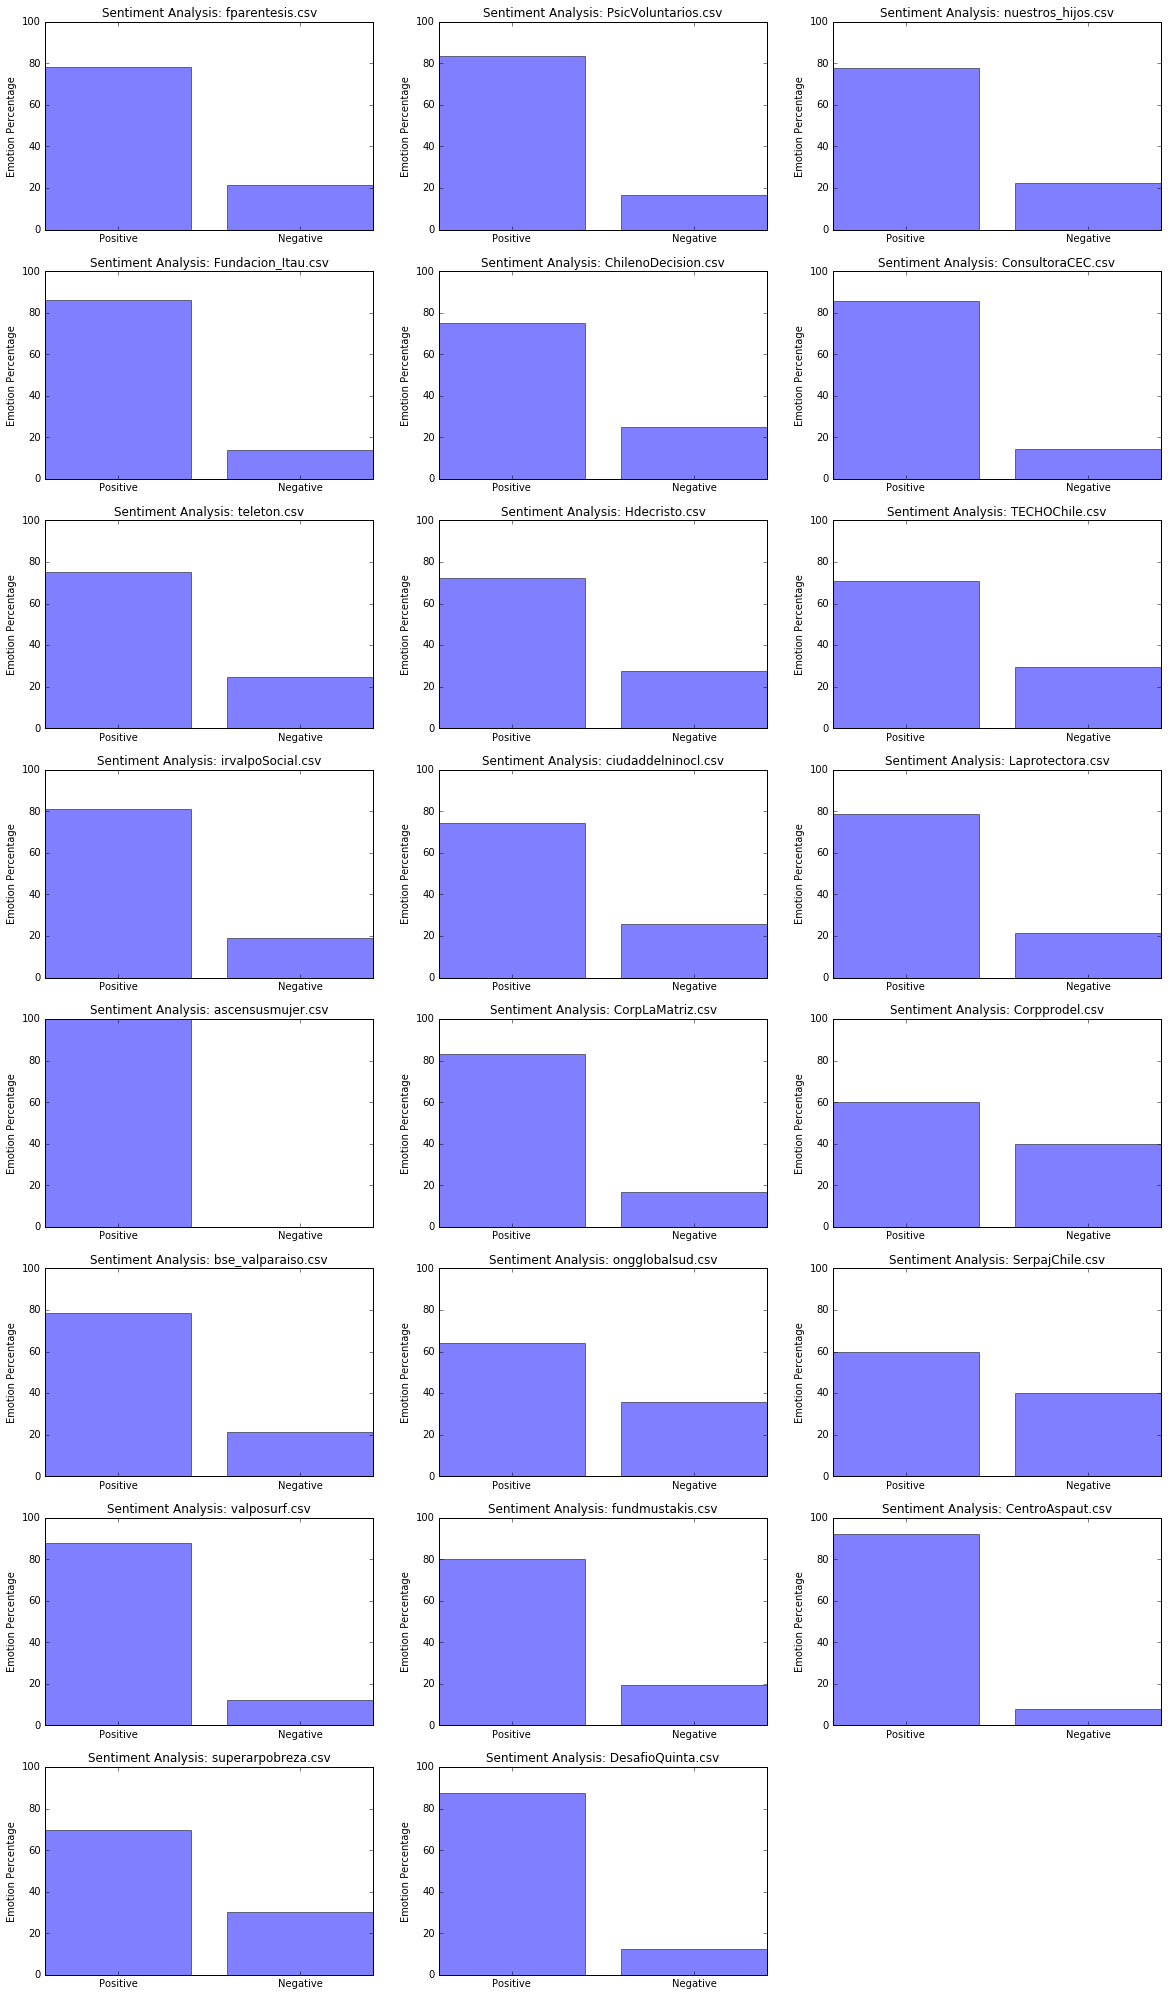

In [22]:
results_twitter = glob.glob("Results/ONG/Twitter/*.csv")
results_facebook = glob.glob("Results/ONG/Facebook/*.csv")

plt.figure(figsize=(20,35))
objects_p = ('Positive', 'Negative')
y_pos = np.arange(len(objects_p))


i = 1
for f in results_twitter:    
    predicted = pd.read_csv(f)
    sh = predicted.shape[0]
    prediction = [predicted.query('polarity == 1').shape[0]/float(sh)*100, predicted.query('polarity == 0').shape[0]/float(sh)*100]
    plt.subplot(8,3,i) 
    plt.bar(y_pos, prediction, align='center', alpha=0.5)
    plt.xticks(y_pos, objects_p)
    plt.ylabel('Emotion Percentage')
    plt.ylim((0,100))
    plt.title('Sentiment Analysis: '+f.split('/')[-1])
    i+=1

plt.show()

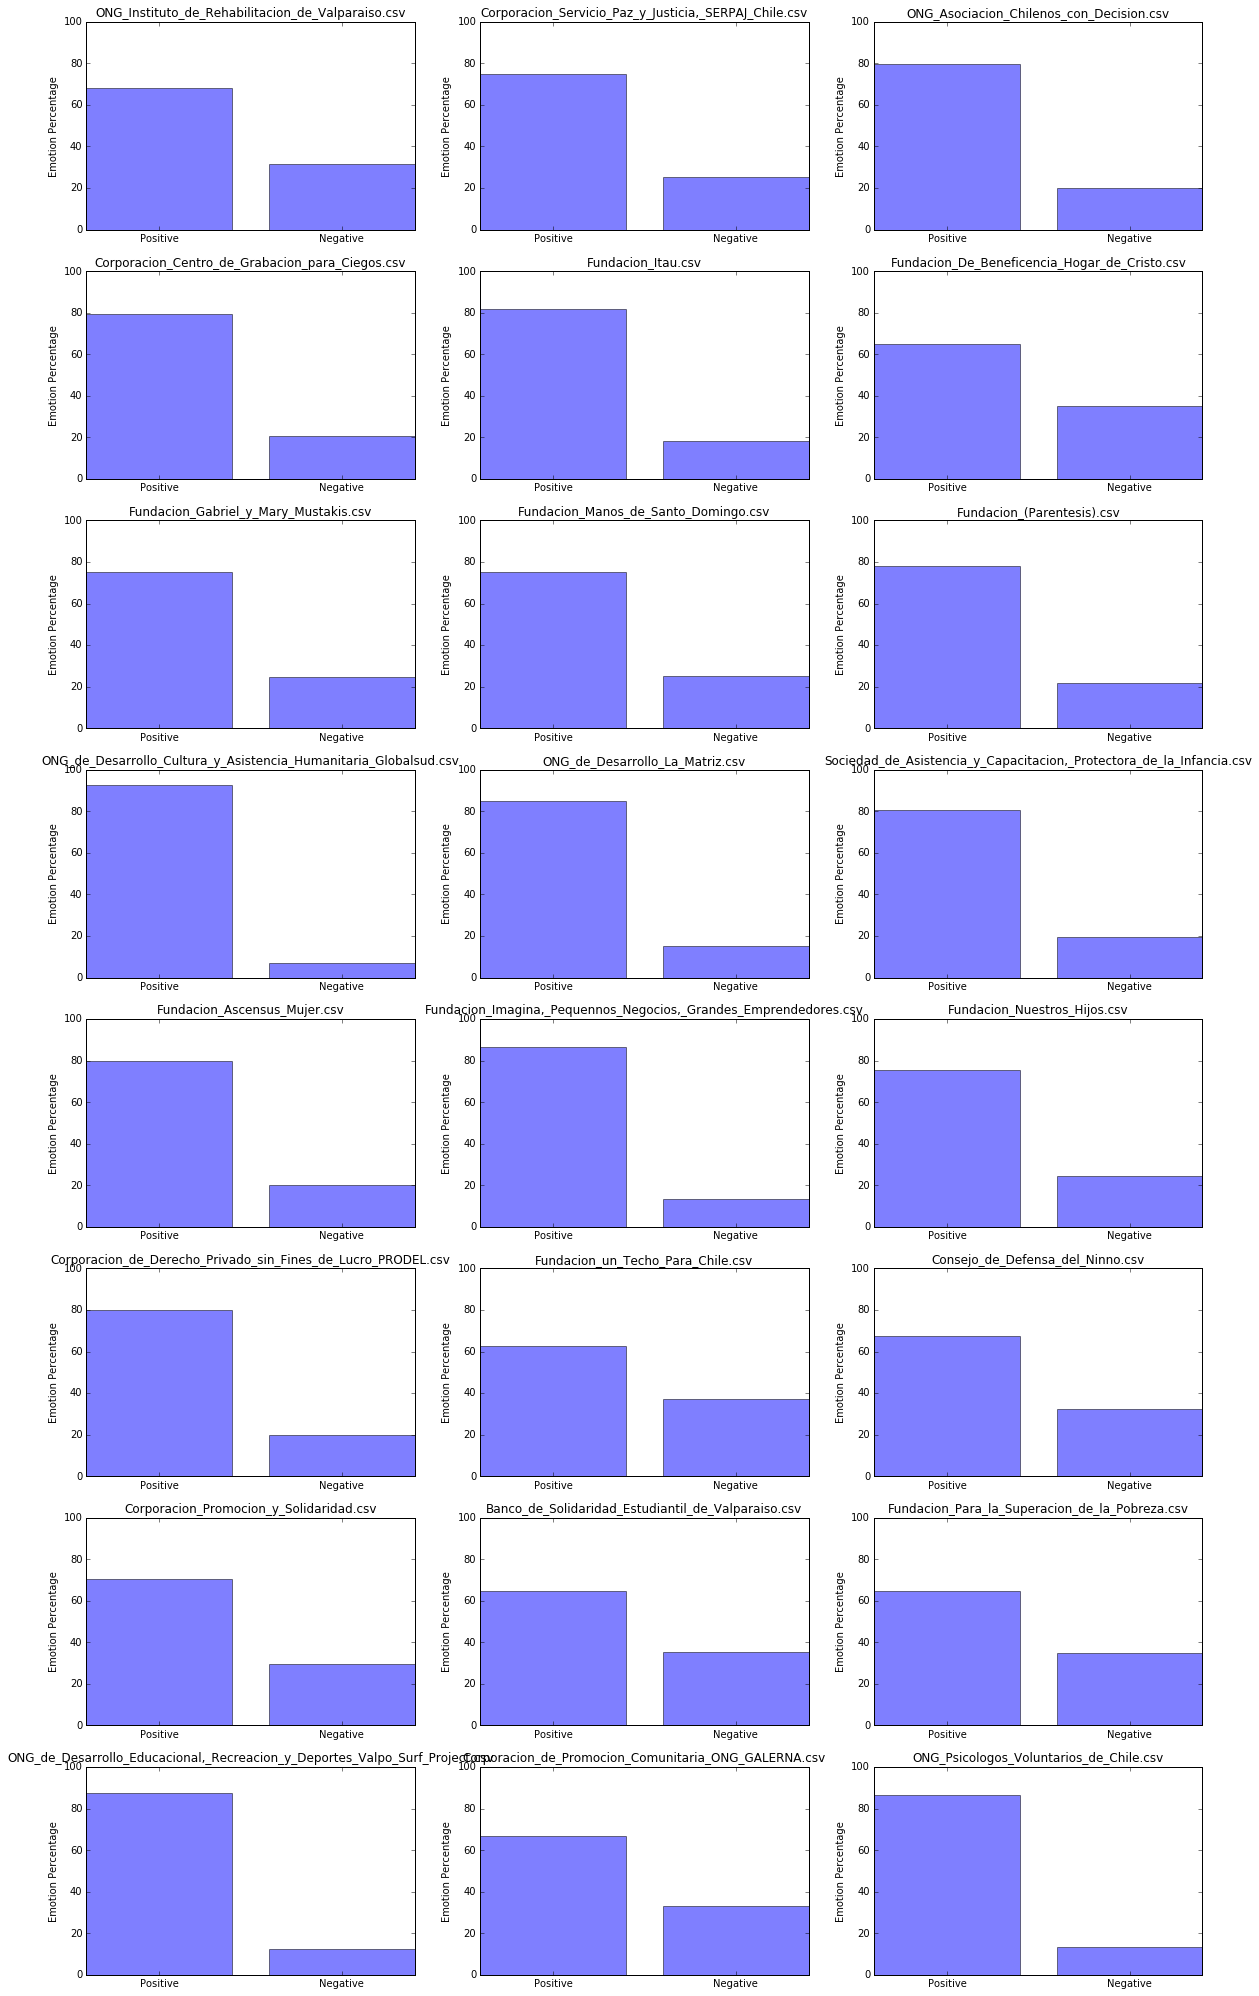

In [24]:

plt.figure(figsize=(20,35))
objects_p = ('Positive', 'Negative')
y_pos = np.arange(len(objects_p))


i = 1
for f in results_facebook:    
    predicted = pd.read_csv(f)
    sh = predicted.shape[0]
    prediction = [predicted.query('polarity == 1').shape[0]/float(sh)*100, predicted.query('polarity == 0').shape[0]/float(sh)*100]
    plt.subplot(8,3,i) 
    plt.bar(y_pos, prediction, align='center', alpha=0.5)
    plt.xticks(y_pos, objects_p)
    plt.ylabel('Emotion Percentage')
    plt.ylim((0,100))
    plt.title(f.split('/')[-1])
    i+=1

plt.show()